## ViT Predictions

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from roboflow import Roboflow
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
df_results = pd.read_csv(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\metadata_full_July.csv")

## ViT Evaluation


=== Evaluation Metrics ===
Accuracy: 0.8900
Macro F1 Score: 0.8747

                precision    recall  f1-score   support

   Clear Water       0.84      0.86      0.85       341
   Common reed       0.95      0.97      0.96       610
      Duckweed       0.81      0.92      0.86       263
         Other       0.93      0.92      0.92       591
Water-starwort       0.84      0.73      0.78       395

      accuracy                           0.89      2200
     macro avg       0.87      0.88      0.87      2200
  weighted avg       0.89      0.89      0.89      2200



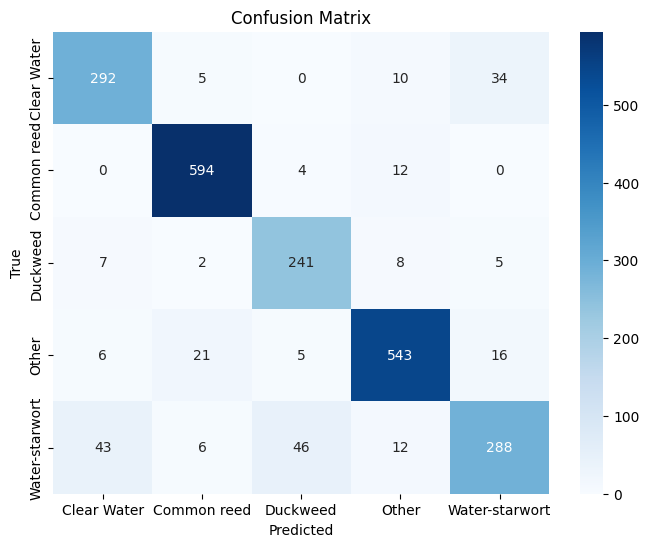

In [4]:
# === 5. Evaluatie ===
y_true = df_results['true_label']
y_pred = df_results['pred_label']

print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}\n")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [5]:
# Check for unexpected labels
print("Unique true labels:", sorted(df_results['true_label'].unique()))
print("Unique predicted labels:", sorted(df_results['pred_label'].unique()))

Unique true labels: ['Clear Water', 'Common reed', 'Duckweed', 'Other', 'Water-starwort']
Unique predicted labels: ['Clear Water', 'Common reed', 'Duckweed', 'Other', 'Water-starwort']


## ViT wrong patches

In [2]:
import os
import pandas as pd
import shutil

# === CONFIGURATION ===
PREDICTIONS_CSV = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\predictions_output.csv"
TEST_PATCH_DIR  = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\Definitief_29_04\Test_dataset\test_v5_resize"
WRONG_DIR       = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\wrong_predictions"

# Create output directory
os.makedirs(WRONG_DIR, exist_ok=True)

# --- 1. Load predictions DataFrame ---
df = pd.read_csv(PREDICTIONS_CSV)

# --- 2. Build mapping: normalized patch_name -> full image path ---
patch_map = {}
for class_name in os.listdir(TEST_PATCH_DIR):
    class_dir = os.path.join(TEST_PATCH_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        # normalize by removing '_rf.<hash>' and keeping extension .jpg
        base = os.path.splitext(img_file)[0]
        normalized = base.rsplit("_jpg", 1)[0] + ".jpg"
        patch_map[normalized] = os.path.join(class_dir, img_file)

# --- 3. Iterate wrong predictions and copy to folders ---
wrong_rows = df[df['true_label'] != df['pred_label']]
for _, row in wrong_rows.iterrows():
    patch_name = row['patch_filename']
    true_cls = row['true_label']
    pred_cls = row['pred_label']
    src_path = patch_map.get(patch_name)
    if not src_path or not os.path.exists(src_path):
        print(f"Warning: file not found for {patch_name}")
        continue

    # Create subfolder for this truth→prediction
    subfolder = f"{true_cls}_to_{pred_cls}"
    dst_dir = os.path.join(WRONG_DIR, subfolder)
    os.makedirs(dst_dir, exist_ok=True)

    # Copy image
    shutil.copy(src_path, os.path.join(dst_dir, os.path.basename(src_path)))

print(f"Copied {len(wrong_rows)} wrong predictions into {WRONG_DIR}")


Copied 242 wrong predictions into C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\wrong_predictions


## Analysis of predictions of VGG16 and ViT

In [3]:
## Analysis of predictions for VGG16 and ViT ##

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# === 0. CONFIGURATION ===
models_info = {
    "vgg16": {
        "csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\confidence_scores.csv",
        "analysis_dir": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\analysis"
    },
    "ViT": {
        "csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\predictions_output.csv",
        "analysis_dir": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\analysis"
    }
}

# Ensure analysis directories exist
for info in models_info.values():
    os.makedirs(info["analysis_dir"], exist_ok=True)

# === 1. ANALYSIS PER MODEL ===
metrics_summary = []
per_class_f1 = {}

for name, info in models_info.items():
    # Load and normalize columns
    df = pd.read_csv(info["csv"])
    if name == "vgg16":
        df = df.rename(columns={"true": "true", "pred": "pred"})[["true","pred","confidence"]]
    else:
        df = df.rename(columns={"true_label":"true", "pred_label":"pred"})[["true","pred","confidence"]]
    
    # Compute aggregate metrics
    acc = accuracy_score(df["true"], df["pred"])
    mac_f1 = f1_score(df["true"], df["pred"], average="macro")
    wei_f1 = f1_score(df["true"], df["pred"], average="weighted")
    prec = precision_score(df["true"], df["pred"], average="macro")
    rec = recall_score(df["true"], df["pred"], average="macro")
    
    # Save summary metrics
    metrics_summary.append({
        "model": name,
        "accuracy": acc,
        "macro_f1": mac_f1,
        "weighted_f1": wei_f1,
        "precision_macro": prec,
        "recall_macro": rec
    })
    pd.DataFrame([metrics_summary[-1]]).to_csv(
        os.path.join(info["analysis_dir"], "metrics_summary.csv"), index=False
    )
    
    # Classification report
    report = classification_report(df["true"], df["pred"], digits=4)
    with open(os.path.join(info["analysis_dir"], "classification_report.txt"), "w") as f:
        f.write(report)
    
    # Confusion matrix
    labels = sorted(df["true"].unique())
    cm = confusion_matrix(df["true"], df["pred"], labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.to_csv(os.path.join(info["analysis_dir"], "confusion_matrix.csv"))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", square=True)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(info["analysis_dir"], "confusion_matrix.png"))
    plt.close()
    
    # Per-class F1
    f1s = []
    for cls in labels:
        f1s.append(f1_score(df["true"], df["pred"], labels=[cls], average="macro"))
    per_class_f1[name] = {"classes": labels, "f1s": f1s}
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=labels, y=f1s, palette="viridis")
    plt.title(f"{name} Per-Class F1 Score")
    plt.ylabel("F1 Score")
    plt.ylim(0,1)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(info["analysis_dir"], "per_class_f1.png"))
    plt.close()
    
    # Confidence distributions
    plt.figure(figsize=(8,5))
    sns.histplot(df["confidence"], bins=20, kde=True)
    plt.title(f"{name} Confidence Distribution")
    plt.xlabel("Confidence")
    plt.tight_layout()
    plt.savefig(os.path.join(info["analysis_dir"], "confidence_distribution.png"))
    plt.close()
    
    df["correct"] = df["true"] == df["pred"]
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x="confidence", hue="correct", bins=20, kde=True, palette={True:"green",False:"red"})
    plt.title(f"{name} Confidence: Correct vs Incorrect")
    plt.xlabel("Confidence")
    plt.tight_layout()
    plt.savefig(os.path.join(info["analysis_dir"], "confidence_correct_vs_incorrect.png"))
    plt.close()

# === 2. COMPARISON PLOTS ===
# Summary metrics table
metrics_df = pd.DataFrame(metrics_summary)
metrics_df.to_csv(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\metrics_comparison.csv", index=False)

# Bar plot: Accuracy and Macro F1 comparison
plt.figure(figsize=(6,4))
x = np.arange(len(metrics_df))
width = 0.35
plt.bar(x - width/2, metrics_df["accuracy"], width, label="Accuracy", color="skyblue")
plt.bar(x + width/2, metrics_df["macro_f1"], width, label="Macro F1", color="steelblue")
plt.xticks(x, metrics_df["model"])
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs Macro F1")
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\model_comparison_metrics.png")
plt.close()

# Combined per-class F1 comparison
plt.figure(figsize=(10,6))
classes = per_class_f1["vgg16"]["classes"]
x = np.arange(len(classes))
width = 0.35
plt.bar(x - width/2, per_class_f1["vgg16"]["f1s"], width, label="VGG16", color="blue")
plt.bar(x + width/2, per_class_f1["ViT"]["f1s"], width, label="ViT", color="green")
plt.xticks(x, classes, rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.title("Per-Class F1: VGG16 vs ViT")
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\per_class_f1_comparison.png")
plt.close()


C:\Users\Sander\AppData\Local\Temp\ipykernel_18964\3920730765.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1s, palette="viridis")
C:\Users\Sander\AppData\Local\Temp\ipykernel_18964\3920730765.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1s, palette="viridis")


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

# === 0. CONFIGURATION ===
# Fill in your actual file paths here
results = {
    "vgg16": {
        "July": {
            "pred_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\confidence_scores.csv",
            "confmat_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\benchmark_confusion_matrix.csv"
        },
        "October": {
            "pred_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\vgg16\confidence_scores.csv",
            "confmat_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\vgg16\analysis\confusion_matrix.csv"
        }
    },
    "ViT": {
        "July": {
            "pred_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\predictions_output.csv",
            "confmat_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\confusion_matrix.csv"
        },
        "October": {
            "pred_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\predictions_output.csv",
            "confmat_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\analysis\confusion_matrix.csv"
        }
    }
}

output_dir = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\comparison"
os.makedirs(output_dir, exist_ok=True)

# === 1. AGGREGATE MACRO-F1 TABLE ===
macro_f1 = []
for model, seasons in results.items():
    for season, paths in seasons.items():
        df = pd.read_csv(paths["pred_csv"])
        # normalize column names
        if model=="vgg16":
            y_true = df["true"]
            y_pred = df["pred"]
        else:
            y_true = df["true_label"]
            y_pred = df["pred_label"]
        m = f1_score(y_true, y_pred, average="macro")
        macro_f1.append({"model": model, "season": season, "macro_f1": m})
macro_df = pd.DataFrame(macro_f1)
macro_df.to_csv(os.path.join(output_dir, "macro_f1_comparison.csv"), index=False)

# Plot grouped bar
plt.figure(figsize=(6,4))
sns.barplot(data=macro_df, x="season", y="macro_f1", hue="model", palette=["blue","green"])
plt.ylim(0,1)
plt.ylabel("Macro F₁ Score")
plt.title("Macro F₁ by Model and Season")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "macro_f1_by_season.png"))
plt.close()

# === 2. PER-CLASS F1 HEATMAP ===
for model, seasons in results.items():
    classes = None
    f1_matrix = {}
    for season, paths in seasons.items():
        df = pd.read_csv(paths["pred_csv"])
        if model=="vgg16":
            y_true = df["true"]
            y_pred = df["pred"]
        else:
            y_true = df["true_label"]
            y_pred = df["pred_label"]
        # compute per-class f1
        cls = sorted(y_true.unique())
        classes = cls
        f1s = []
        for c in cls:
            f1s.append(f1_score(y_true, y_pred, labels=[c], average="macro"))
        f1_matrix[season] = f1s
    heat_df = pd.DataFrame(f1_matrix, index=classes)
    heat_df.to_csv(os.path.join(output_dir, f"{model}_per_class_f1.csv"))
    plt.figure(figsize=(6,5))
    sns.heatmap(heat_df, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1)
    plt.title(f"{model} Per-Class F₁ Across Seasons")
    plt.ylabel("Class")
    plt.xlabel("Season")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model}_per_class_f1_heatmap.png"))
    plt.close()

# === 3. DELTA F1 BAR CHART ===
delta = []
for model, df in results.items():
    # load per-class f1 data
    f = pd.read_csv(os.path.join(output_dir, f"{model}_per_class_f1.csv"), index_col=0)
    delta_vals = f["October"] - f["July"]
    for cls, dv in delta_vals.items():
        delta.append({"model": model, "class": cls, "delta_f1": dv})
delta_df = pd.DataFrame(delta)
delta_df.to_csv(os.path.join(output_dir, "delta_f1.csv"), index=False)

plt.figure(figsize=(8,4))
sns.barplot(data=delta_df, x="class", y="delta_f1", hue="model", palette=["blue","green"])
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Δ F₁ (Oct − July)")
plt.xticks(rotation=45, ha="right")
plt.title("Change in Per-Class F₁ from July to October")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "delta_f1_per_class.png"))
plt.close()

# === 4. CONFUSION MATRIX DIFFERENCE ===
for model, seasons in results.items():
    cm_j = pd.read_csv(seasons["July"]["confmat_csv"], index_col=0)
    cm_o = pd.read_csv(seasons["October"]["confmat_csv"], index_col=0)
    diff = cm_o - cm_j
    diff.to_csv(os.path.join(output_dir, f"{model}_confmat_diff.csv"))
    plt.figure(figsize=(6,5))
    sns.heatmap(diff, annot=True, center=0, cmap="vlag", fmt="d")
    plt.title(f"{model} Confusion Matrix Difference (Oct−July)")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model}_confmat_diff.png"))
    plt.close()



## change to original altitude

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ExifTags

# === CONFIGURATION ===
METADATA_CSV     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July.csv"
RAW_PHOTO_DIR    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\Testing data\test data"
OUTPUT_CSV       = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July_updated.csv"

# Helpers
def to_float(r):
    try:
        return float(r.numerator) / r.denominator
    except:
        return float(r)

# Precompute EXIF tag IDs
GPS_TAG = next(k for k,v in ExifTags.TAGS.items() if v=="GPSInfo")

# ─── 1. Read your merged July metadata ────────────────────────────────────────
df = pd.read_csv(METADATA_CSV)

# ─── 2. Build EXIF lookup ────────────────────────────────────────────────────
exif_alt = {}
for fname in os.listdir(RAW_PHOTO_DIR):
    if not fname.lower().endswith((".jpg","jpeg","png")):
        continue

    base, _    = os.path.splitext(fname)       # e.g. "F2_0087"
    segment, raw_pid = base.split("_", 1)      # raw_pid == "0087"
    pid        = str(int(raw_pid))             # pid == "87"

    path = os.path.join(RAW_PHOTO_DIR, fname)
    img  = Image.open(path)
    raw  = img._getexif() or {}

    alt = np.nan
    if GPS_TAG in raw:
        gps = {ExifTags.GPSTAGS.get(t,t):v for t,v in raw[GPS_TAG].items()}
        if "GPSAltitude" in gps:
            alt = to_float(gps["GPSAltitude"])

    exif_alt[(segment, pid)] = alt

# ─── 3. Debug print for your failing patch ────────────────────────────────────
print("EXIF altitudes for key ('F2','87'):", exif_alt.get(("F2","87")))

# ─── 4. Map back into DataFrame ──────────────────────────────────────────────
def lookup_alt(row):
    key = (row["segment"], str(int(row["photo_id"])))
    return exif_alt.get(key, np.nan)

df["flight_altitude"] = df.apply(lookup_alt, axis=1)

# ─── 5. Save updated CSV ─────────────────────────────────────────────────────
df.to_csv(OUTPUT_CSV, index=False)
print("Written updated metadata to:", OUTPUT_CSV)


EXIF altitudes for key ('F2','87'): 84.797
Written updated metadata to: C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July_updated.csv


## check

In [6]:
import os
import pandas as pd

# === CONFIG ===
TEST_PATCH_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\Definitief_29_04\Test_dataset\test_v5_resize"
FULL_META_CSV  = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July_updated.csv"

# Build the folder‐based truth map
truth_map = {}
for cls in os.listdir(TEST_PATCH_DIR):
    cls_dir = os.path.join(TEST_PATCH_DIR, cls)
    if not os.path.isdir(cls_dir): continue
    for fn in os.listdir(cls_dir):
        base = os.path.splitext(fn)[0].split("_jpg")[0] + ".jpg"
        truth_map[base] = cls

# Load your final CSV
df = pd.read_csv(FULL_META_CSV)

# Compare
df['derived_true'] = df['patch_filename'].map(truth_map)
mism = df[df['true_label'] != df['derived_true']]

print(f"Total rows: {len(df)}")
print(f"Mismatches: {len(mism)} ({len(mism)/len(df)*100:.2f}%)")
if not mism.empty:
    print("\nSample mismatches:")
    print(mism[['patch_filename','true_label','derived_true']].head(10))

    # Optional: save them for inspection
    out = os.path.join(os.path.dirname(FULL_META_CSV),"label_mismatches.csv")
    mism.to_csv(out, index=False)
    print(f"\nDetails saved to {out}")


Total rows: 2200
Mismatches: 0 (0.00%)


## Mapping patches back

In [7]:
import os
import math
import pandas as pd
import numpy as np
from shapely.geometry import box
import geopandas as gpd

# === CONFIGURATION ===
METADATA_PATH     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July_updated.csv"
OUTPUT_GEOJSON    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints.geojson"

# Camera sensor dimensions (mm) – replace with your camera's actual specs
SENSOR_WIDTH_MM   = 13.2
SENSOR_HEIGHT_MM  = 8.8

# Constants for lat/lon conversion
METERS_PER_DEG_LAT = 111320.0

# === 1. LOAD METADATA ===
df = pd.read_csv(METADATA_PATH)

# Ensure required columns exist
required = ["latitude","longitude","focal_length_mm","ImageWidth","ImageLength","x_start","y_start","patch_size"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in metadata: {missing}")

# === 2. COMPUTE GSD (m/px) per row ===
df["pitch_x_mm"] = SENSOR_WIDTH_MM / df["ImageWidth"]
df["pitch_y_mm"] = SENSOR_HEIGHT_MM / df["ImageLength"]
df["GSD_x"] = df["flight_altitude"] * df["pitch_x_mm"] / df["focal_length_mm"]
df["GSD_y"] = df["flight_altitude"] * df["pitch_y_mm"] / df["focal_length_mm"]

# Precompute cos(lat) factor
df["cos_lat"] = np.cos(np.deg2rad(df["latitude"]))

# === 3. FUNCTION TO COMPUTE PATCH POLYGON GEOFOOTPRINT ===
def compute_footprint(row):
    x0, y0, ps = row["x_start"], row["y_start"], row["patch_size"]
    # define pixel corners (image coords: origin top-left, y down)
    pix_corners = [(x0, y0), (x0+ps, y0), (x0+ps, y0+ps), (x0, y0+ps)]
    geo_coords = []
    for px, py in pix_corners:
        # offsets from image center
        dx = (px - row["ImageWidth"]/2) * row["GSD_x"]
        dy = -(py - row["ImageLength"]/2) * row["GSD_y"]
        # convert to lat/lon
        lat = row["latitude"] + dy / METERS_PER_DEG_LAT
        lon = row["longitude"] + dx / (METERS_PER_DEG_LAT * row["cos_lat"])
        geo_coords.append((lon, lat))
    # build bounding box from coords
    minx = min(pt[0] for pt in geo_coords)
    maxx = max(pt[0] for pt in geo_coords)
    miny = min(pt[1] for pt in geo_coords)
    maxy = max(pt[1] for pt in geo_coords)
    return box(minx, miny, maxx, maxy)

# === 4. CREATE GeoDataFrame AND SAVE ===
gdf = gpd.GeoDataFrame(
    df,
    geometry=df.apply(compute_footprint, axis=1),
    crs="EPSG:4326"
)
gdf.to_file(OUTPUT_GEOJSON, driver="GeoJSON")
print(f"Saved patch footprints to {OUTPUT_GEOJSON}")


Saved patch footprints to C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints.geojson


In [8]:
import geopandas as gpd

# 1. Read the lat/lon (EPSG:4326) footprints you just created
gdf = gpd.read_file(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints.geojson")

# 2. Assign the correct source CRS (if not already set)
gdf = gdf.set_crs("EPSG:4326", allow_override=True)

# 3. Reproject into your projected CRS
#    Replace EPSG:32631 with the code that matches your orthomosaic
gdf_proj = gdf.to_crs("EPSG:32631")

# 4. Save out the reprojected footprints
gdf_proj.to_file(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints_32631.geojson", driver="GeoJSON")

print("Reprojected to EPSG:32631, saved to patch_footprints_projected.geojson")


Reprojected to EPSG:32631, saved to patch_footprints_projected.geojson


In [9]:
import geopandas as gpd

# 1. Read the lat/lon (EPSG:4326) footprints you just created
gdf = gpd.read_file(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints.geojson")

# 2. Assign the correct source CRS (if not already set)
gdf = gdf.set_crs("EPSG:4326", allow_override=True)

# 3. Reproject into your projected CRS
#    Replace EPSG:32631 with the code that matches your orthomosaic
gdf_proj = gdf.to_crs("EPSG:31370")

# 4. Save out the reprojected footprints
gdf_proj.to_file(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints_31370.geojson", driver="GeoJSON")

print("Reprojected to EPSG:31370, saved to patch_footprints_projected.geojson")


Reprojected to EPSG:31370, saved to patch_footprints_projected.geojson


In [ ]:
import os
import math
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import box
import geopandas as gpd

# === CONFIGURATION ===
DEM_PATH         = r"C:\[…]\dem.tif"                # your Metashape‐exported DEM
METADATA_PATH     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July.csv"
OUTPUT_GEOJSON    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints.geojson"

# Constants
DEG_TO_M_LAT     = 111320.0      # m per degree latitude

# === 1. LOAD INPUTS ===
df = pd.read_csv(METADATA_PATH)
dem = rasterio.open(DEM_PATH)
dem_arr = dem.read(1)
dem_tf  = dem.transform

# helper to sample DEM elevation at lon/lat
def sample_dem(lon, lat):
    row, col = dem.index(lon, lat)
    return float(dem_arr[row, col])

# === 2. DERIVE SENSOR SIZE FROM EXIF ===
# If your metadata has 'ImageWidth', 'ImageLength', 'focal_length_mm', 'focal_length_35mm'
diag35 = 43.27  # 35mm diagonal in mm
w_px = df['ImageWidth']
h_px = df['ImageLength']
f_mm = df['focal_length_mm']
f35   = df['focal_length_35mm']

# sensor diagonal (mm) from ratio of focal lengths
df['sensor_diag_mm']  = f_mm / f35 * diag35
# aspect ratio
df['aspect']          = w_px / h_px
# sensor height & width (mm)
df['sensor_h_mm']     = df['sensor_diag_mm'] / np.sqrt(df['aspect']**2 + 1)
df['sensor_w_mm']     = df['sensor_h_mm'] * df['aspect']

# === 3. COMPUTE ALTITUDE ABOVE GROUND (AGL) ===
# assume your metadata GPSAltitude column is "flight_altitude_masl"
df['ground_elev'] = df.apply(lambda r: sample_dem(r['longitude'], r['latitude']), axis=1)
df['altitude_agl'] = df['flight_altitude_masl'] - df['ground_elev']

# === 4. COMPUTE GSD (m/px) ===
df['pitch_x_mm'] = df['sensor_w_mm'] / w_px
df['pitch_y_mm'] = df['sensor_h_mm'] / h_px
df['GSD_x']      = df['altitude_agl'] * df['pitch_x_mm'] / f_mm
df['GSD_y']      = df['altitude_agl'] * df['pitch_y_mm'] / f_mm
df['cos_lat']    = np.cos(np.deg2rad(df['latitude']))

# === 5. BUILD PATCH POLYGONS ===
polys = []
for _, r in df.iterrows():
    x0, y0, ps = r['x_start'], r['y_start'], r['patch_size']
    corners = [
        (x0,    y0),
        (x0+ps, y0),
        (x0+ps, y0+ps),
        (x0,    y0+ps)
    ]
    geo = []
    for px, py in corners:
        dx = (px - w_px.loc[_]/2) * r['GSD_x']
        dy = -(py - h_px.loc[_]/2) * r['GSD_y']
        lat = r['latitude'] + dy / DEG_TO_M_LAT
        lon = r['longitude'] + dx / (DEG_TO_M_LAT * r['cos_lat'])
        geo.append((lon, lat))
    polys.append(box(*(
        min(pt[0] for pt in geo),
        min(pt[1] for pt in geo),
        max(pt[0] for pt in geo),
        max(pt[1] for pt in geo)
    )))

# === 6. EXPORT GEOJSON ===
gdf = gpd.GeoDataFrame(df, geometry=polys, crs="EPSG:4326")
gdf.to_file(OUTPUT_GEOJSON, driver="GeoJSON")
print("Saved GSD-based footprints to:", OUTPUT_GEOJSON)


In [19]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import Polygon
import geopandas as gpd

# === CONFIGURATION ===
CAMERAS_XML     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\cameras.xml"
DEM_PATH        = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\F15_dem.tif"
META_CSV    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July_updated.csv"
OUTPUT_GEOJSON  = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints_option2.geojson"


# === 1. PARSE Metashape XML ===
tree = ET.parse(CAMERAS_XML)
root = tree.getroot()

# 1a. Extract adjusted intrinsics from each <sensor>
sensor_intrinsics = {}
for sensor in root.findall(".//sensors/sensor"):
    sid   = sensor.get("id")
    calib = sensor.find("./calibration[@class='adjusted']")
    if calib is None:
        raise RuntimeError(f"Sensor {sid} missing adjusted calibration")
    fx = float(calib.find("f").text)
    cx = float(calib.find("cx").text)
    cy = float(calib.find("cy").text)
    sensor_intrinsics[sid] = (fx, fx, cx, cy)

# 1b. Extract extrinsics from each <camera> and build photo-id lookup
cameras = {}
by_pid  = {}
for cam_node in root.findall(".//cameras/camera"):
    label     = cam_node.get("label")       # e.g. "DJI_20240730173659_0091_D"
    sid       = cam_node.get("sensor_id")
    fx, fy, cx, cy = sensor_intrinsics[sid]

    # parse the 4×4 <transform>
    raw = cam_node.find("transform").text.strip().split()
    nums = [float(v) for v in raw]
    if len(nums) == 16:
        M = [nums[i*4:(i+1)*4] for i in range(4)]
    else:
        M = []
        for line in cam_node.find("transform").text.splitlines():
            vals = line.strip().split()
            if len(vals) == 4:
                M.append([float(v) for v in vals])
    R = [M[i][:3] for i in range(3)]
    t = [M[i][3]    for i in range(3)]

    cameras[label] = {"fx":fx, "fy":fy, "cx":cx, "cy":cy, "R":R, "t":t}

    # extract the photo_id (penultimate underscore-separated token)
    pid = label.split("_")[-2]  
    by_pid[pid] = label

print(f"Loaded {len(cameras)} cameras, built photo-id lookup of size {len(by_pid)}")

# === 2. LOAD DEM and helper ===
dem     = rasterio.open(DEM_PATH)
dem_arr = dem.read(1)
dem_crs = dem.crs

def sample_dem(lon, lat):
    row, col = dem.index(lon, lat)
    return float(dem_arr[row, col])

# === 3. LOAD & FILTER METADATA for segment F15 ===
df = pd.read_csv(METADATA_CSV)
df = df[df["segment"] == "F15"].reset_index(drop=True)

# === 4. DEFINE collinearity projection ===
def pixel_to_world(cam, u, v, z_elev):
    fx,fy,cx,cy = cam["fx"],cam["fy"],cam["cx"],cam["cy"]
    R = np.array(cam["R"])
    t = np.array(cam["t"])
    C = -R.T.dot(t)  # camera center
    x = (u - cx) / fx
    y = (v - cy) / fy
    ray = R.T.dot([x, y, 1.0])
    s = (z_elev - C[2]) / ray[2]
    P = C + s * ray
    return P[0], P[1]

# === 5. BUILD rotated, DEM-accurate polygons ===
polygons = []
for _, row in df.iterrows():
    pid_str = f"{int(row['photo_id']):04d}"
    cam_label = by_pid.get(pid_str)
    if cam_label is None:
        print(f"⚠️  No camera entry for photo_id {pid_str}")
        continue

    cam = cameras[cam_label]
    x0, y0, ps = row["x_start"], row["y_start"], row["patch_size"]
    corners_px = [(x0, y0), (x0+ps, y0), (x0+ps, y0+ps), (x0, y0+ps)]

    z0 = sample_dem(row["longitude"], row["latitude"])
    world_pts = [pixel_to_world(cam, u, v, z0) for u, v in corners_px]
    poly = Polygon(world_pts)

    rec = row.to_dict()
    rec["geometry"] = poly
    polygons.append(rec)

if not polygons:
    raise RuntimeError("No polygons generated—check that photo_id values match your XML labels")

# === 6. EXPORT to GeoJSON ===
df_attrib = pd.DataFrame(polygons).drop(columns=["geometry"])
geoms      = [p["geometry"] for p in polygons]
gdf = gpd.GeoDataFrame(df_attrib, geometry=geoms, crs="EPSG:32631")
gdf.to_file(OUTPUT_GEOJSON, driver="GeoJSON")

print(f"\n✅ Written {len(polygons)} footprints to:\n   {OUTPUT_GEOJSON}")

Loaded 263 cameras, built photo-id lookup of size 263

✅ Written 270 footprints to:
   C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints_option2.geojson


DJI_20240730173659_0091_D

In [21]:
import rasterio
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

# 1. Point this at your orthomosaic GeoTIFF (must be in a projected CRS)
ORTHO_TIF    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\F15_ortho.tif"
META_CSV     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July_updated.csv"
OUTPUT_GEOJSON   = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints_option3.geojson"

# === 1. Open the orthomosaic and grab its geotransform & CRS ===
with rasterio.open(ORTHO_TIF) as ds:
    transform = ds.transform    # Affine mapping pixel→map
    crs       = ds.crs          # e.g. EPSG:32631

# === 2. Load and filter metadata for segment "F15" only ===
df = pd.read_csv(META_CSV)
df_f15 = df[df["segment"] == "F15"].reset_index(drop=True)
print(f"Found {len(df_f15)} patches for segment F15")

# === 3. Build each patch polygon in map coordinates ===
polygons = []
for _, row in df_f15.iterrows():
    x0 = row["x_start"]
    y0 = row["y_start"]
    ps = row["patch_size"]
    # four corners in pixel coordinates
    corners_px = [
        (x0,      y0),
        (x0 + ps, y0),
        (x0 + ps, y0 + ps),
        (x0,      y0 + ps)
    ]
    # map to world (projected) coordinates via the orthomosaic's affine
    world_pts = [transform * (px, py) for px, py in corners_px]
    polygons.append(Polygon(world_pts))

# === 4. Create GeoDataFrame and save ===
gdf = gpd.GeoDataFrame(
    df_f15,
    geometry=polygons,
    crs=crs
)
gdf.to_file(OUTPUT_GEOJSON, driver="GeoJSON")
print("Wrote", len(gdf), "patch footprints to:", OUTPUT_GEOJSON)

Found 270 patches for segment F15
Wrote 270 patch footprints to: C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints_option3.geojson


In [23]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import rasterio
from shapely.geometry import Polygon
from shapely.affinity import rotate
import geopandas as gpd

# ─── 0. CONFIG ──────────────────────────────────────────────────────────────
ORTHO_TIF    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\F15_ortho.tif"
META_CSV     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\metadata_full_July_updated.csv"
OUTPUT_GEOJSON   = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints_option5.geojson"
CAMERAS_XML     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\cameras.xml"

# ─── 1. OPEN ORTHOMOSAIC ───────────────────────────────────────────────────────
with rasterio.open(ORTHO_TIF) as ds:
    transform = ds.transform
    crs       = ds.crs

# ─── 2. LOAD & FILTER METADATA ────────────────────────────────────────────────
df = pd.read_csv(META_CSV)
df = df[df["segment"] == "F15"].reset_index(drop=True)
print(f"{len(df)} patches in F15")

# ─── 3. PARSE YAWS FROM XML ────────────────────────────────────────────────────
tree = ET.parse(CAMERAS_XML)
root = tree.getroot()

yaw_list = []
for cam in root.findall(".//cameras/camera"):
    label = cam.get("label")
    pid   = label.split("_")[-2]           # penultimate token
    ref   = cam.find("reference")
    if ref is not None and "yaw" in ref.attrib:
        yaw_list.append(float(ref.get("yaw")))

if not yaw_list:
    raise RuntimeError("No yaw values found in XML")
# use the median yaw to minimize outliers
global_yaw = float(pd.Series(yaw_list).median())
print(f"Global yaw (median): {global_yaw:.1f}°")

# ─── 4. COMPUTE BLOCK CENTER ─────────────────────────────────────────────────┐
# we want the pixel‐space center of the entire F15 block
x_min = df["x_start"].min()
y_min = df["y_start"].min()
ps    = df["patch_size"].iloc[0]         # assume uniform patch_size
x_max = df["x_start"].max() + ps
y_max = df["y_start"].max() + ps

px_center = (x_min + x_max) / 2
py_center = (y_min + y_max) / 2

# map that to world coords
wx_center, wy_center = transform * (px_center, py_center)
print(f"Block center at map coords: ({wx_center:.2f}, {wy_center:.2f})")

# ─── 5. BUILD + ROTATE PATCH POLYGONS ──────────────────────────────────────────
polygons = []
for _, row in df.iterrows():
    x0, y0 = row["x_start"], row["y_start"]
    corners_px = [
        (x0,      y0),
        (x0 + ps, y0),
        (x0 + ps, y0 + ps),
        (x0,      y0 + ps)
    ]
    # map to world coords
    world_pts = [transform * (px, py) for px, py in corners_px]
    poly = Polygon(world_pts)

    # rotate the entire patch around the block center by -global_yaw
    poly_rot = rotate(
        poly,
        -global_yaw, 
        origin=(wx_center, wy_center),
        use_radians=False
    )

    rec = row.to_dict()
    rec["geometry"] = poly_rot
    polygons.append(rec)

# ─── 6. EXPORT GEOJSON ────────────────────────────────────────────────────────
df_attrib = pd.DataFrame(polygons).drop(columns=["geometry"])
geoms      = [r["geometry"] for r in polygons]
gdf = gpd.GeoDataFrame(df_attrib, geometry=geoms, crs=crs)
gdf.to_file(OUTPUT_GEOJSON, driver="GeoJSON")

print(f"\n✅ Saved {len(gdf)} rotated footprints to:\n   {OUTPUT_GEOJSON}")

270 patches in F15
Global yaw (median): 303.3°
Block center at map coords: (3.61, 51.14)

✅ Saved 270 rotated footprints to:
   C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\mapping_back\patch_footprints_option5.geojson
